# Logistic Regression

1. Prepare Data  
   <ol type="i">
      <li>Data Loader</li>
      <li>Normalizing Data</li>
   </ol>  

2. Designing the model
   <ol type="i">
      <li>input size</li>
      <li>output size</li>
      <li>forward pass</li>
   </ol>  
   
3. Construct loss and optimizer  

4. Training Loop
   <ol type="i">
      <li>forward pass: compute prediction and loss</li>
      <li>backward pass: gradients</li>
      <li>update weights</li>
   </ol>

In [1]:
import torch
import torch.nn as nn
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### 0. Prepare Data

#### i. Loading Breast Cancer Dataset

In [2]:
bc = datasets.load_breast_cancer()
X, y = bc.data, bc.target

# Casting to float32 tensor. Otherwise inferencing stage model(X) runs into a dtype error. 
# Scaling using sklearn.preprocessing.StandardScalar.
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

n_samples, n_features = X.shape

##### ii. Scaling the Input Features

- mean and std. is found only for train data. For test data same mean and std. is used from train set.
- the output features are untouched in preprocessing

In [3]:
X_train = StandardScaler().fit_transform(X_train_unscaled)
X_test = StandardScaler().fit(X_train_unscaled).transform(X_test_unscaled)

# sc = StandardScaler()
# X_train = sc.fit_transform(X_train_unscaled)
# X_test = sc.transform(X_test_unscaled)

#### iii. Casting to float32 tensors adn Trasforming y Vectors

In [4]:
# Casting to float32 tensor. Otherwise inferencing stage model(X) runs into a dtype error. 
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

y_train = y_train.view(-1, 1)
y_test = y_test.view(-1, 1)

### 1. Desining the Model

In [5]:
#One layer neural network
class Model(nn.Module):
    def __init__(self, n_input_features):
        super(Model, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)    #This applies a linear trasformation 
        #While initializing the weights for the matrix as well. Contains learnable parameters.
        #No activation function.

    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred
    
model = Model(n_features)        

### 2. Loss Function and the Optimizer

In [6]:
learning_rate = 0.01

Error = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### 3. Training Loop

In [7]:
num_epochs = 100

for epoch in range(num_epochs):
    
    #Forward pass and loss calculation
    y_pred = model(X_train)
    loss = Error(y_pred, y_train)

    #Backward pass and weight update
    loss.backward()

    #House keeping. Gradient accumilation should be
    #restarted befor new iterations
    optimizer.step()
    optimizer.zero_grad()

    if (epoch+1)%10 == 0:
        print(f'epoch:{epoch+1}, loss: {loss.item():4f}')  


epoch:10, loss: 0.831262
epoch:20, loss: 0.628738
epoch:30, loss: 0.514623
epoch:40, loss: 0.443441
epoch:50, loss: 0.394703
epoch:60, loss: 0.359043
epoch:70, loss: 0.331669
epoch:80, loss: 0.309880
epoch:90, loss: 0.292044
epoch:100, loss: 0.277115


### 4. Evaluations

In [9]:
#Evaluations should be done on test set without the gradients being tracked.

with torch.no_grad():
    y_predicted = model(X_test)
    
    #print(type(y_predicted))
    #print(y_predicted) # This is not rounded to the class. Round to take the
    #nearest class.

    y_preicted_class = y_predicted.round()
    
    #This is how much of y_predicted_class are equal to y_test shown as a percentage.
    accuracy = y_preicted_class.eq(y_test).sum() / float(y_test.shape[0])
    print(f'accuracy: {accuracy.item():.4f}')

accuracy: 0.9035


## Foot Notes

### 1. sklearn.preprocessing.StandardScaler

- StandardScaler removes the mean and scales the data to unit variance. The outliers have an influence when computing the empirical mean and standard deviation. StandardScaler therefore cannot guarantee balanced feature scales in the presence of outliers.

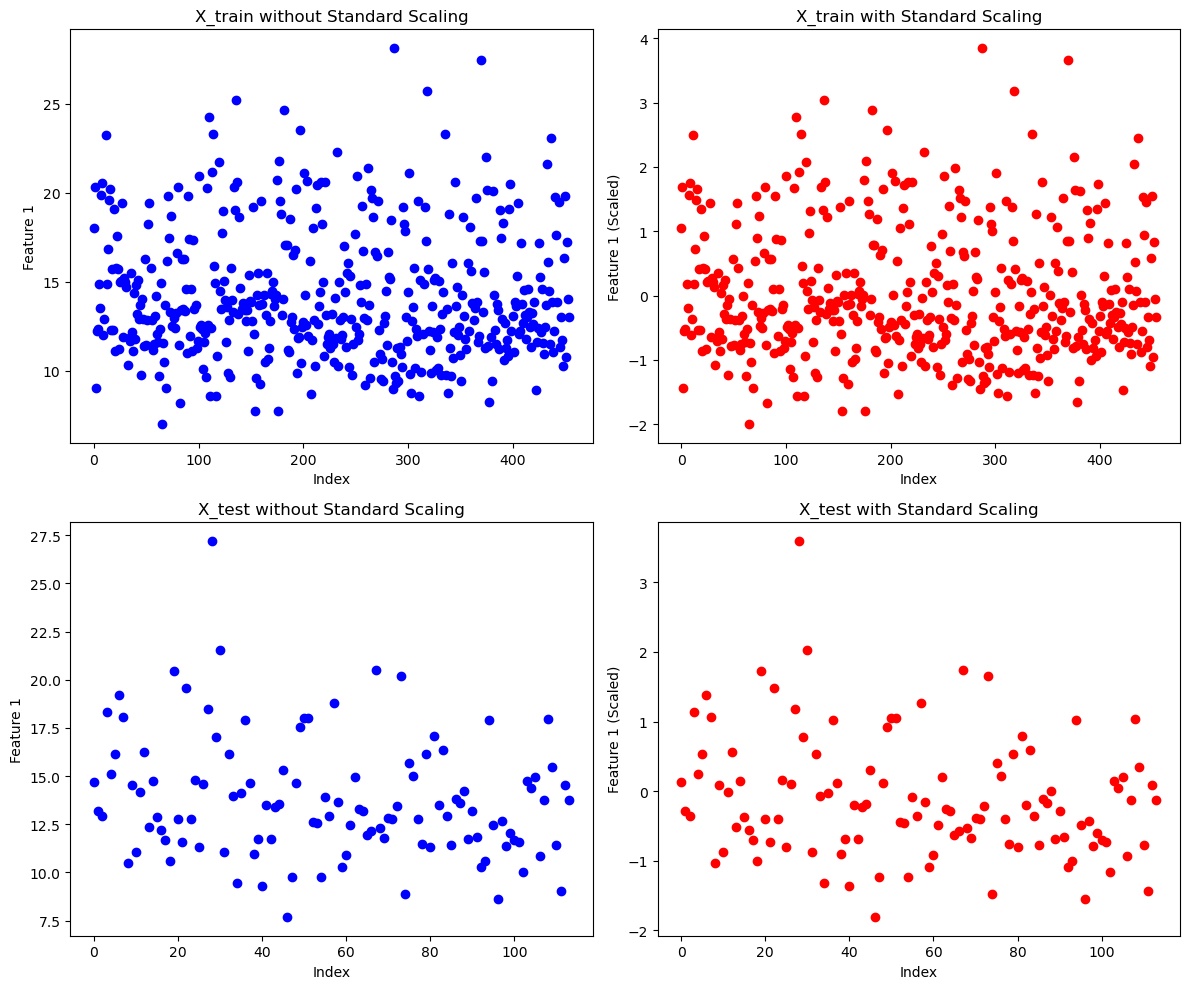

In [ ]:
# Create a figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot X_train without scaling
axs[0, 0].scatter(range(len(X_train_unscaled)), X_train_unscaled[:, 0], color='blue', label='X_train')
axs[0, 0].set_title('X_train without Standard Scaling')
axs[0, 0].set_xlabel('Index')
axs[0, 0].set_ylabel('Feature 1')

# Plot X_train with scaling
axs[0, 1].scatter(range(len(X_train)), X_train[:, 0], color='red', label='X_train Scaled')
axs[0, 1].set_title('X_train with Standard Scaling')
axs[0, 1].set_xlabel('Index')
axs[0, 1].set_ylabel('Feature 1 (Scaled)')

# Plot X_test without scaling
axs[1, 0].scatter(range(len(X_test_unscaled)), X_test_unscaled[:, 0], color='blue', label='X_test')
axs[1, 0].set_title('X_test without Standard Scaling')
axs[1, 0].set_xlabel('Index')
axs[1, 0].set_ylabel('Feature 1')

# Plot X_test with scaling
axs[1, 1].scatter(range(len(X_test)), X_test[:, 0], color='red', label='X_test Scaled')
axs[1, 1].set_title('X_test with Standard Scaling')
axs[1, 1].set_xlabel('Index')
axs[1, 1].set_ylabel('Feature 1 (Scaled)')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


- sklearn.preprocessing.StandardScaler.fit_transform
  - The fit method is calculating the mean and variance of each of the features present in our data. The transform method is transforming all the features using the respective mean and variance.

- sklearn.preprocessing.StandardScaler.transform
  - Using the transform method we can use the same mean and variance as it is calculated from our training data to transform our test data. Thus, the parameters learned by our model using the training data will help us to transform our test data.

- Why we use .fit_trasform on train data and .trasform on test data
  - If we will use the fit method on our test data too, we will compute a new mean and variance that is a new scale for each feature and will let our model learn about our test data too. Thus, what we want to keep as a surprise is no longer unknown to our model and we will not get a good estimate of how our model is performing on the test (unseen) data which is the ultimate goal of building a model using machine learning algorithm.

### 2. breast cancer wisconsin dataset

sklearn.datasets provides few toy datasets. This is a dataset on a binary classification with 569 datapoints with 30 features.

### 3. sklearn.model_selection.train_test_split

- train/test split ratio is taken around 80%, 20% for smaller datasets.

In [ ]:
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### 4. Binary Cross Entropy

- Problem 
  -  if x_n is either 0 or 1, one of the log terms would be mathematically undefined in Cross Entropy Loss. 
  - if either y = 0 or y =1, then we would be multiplying 0 with infinity. 
  -  we would also have an infinite term in our gradient which  would make BCELoss’s backward method nonlinear with respect to x_n
- Answer 
  - BCELoss clamps its log function outputs to be greater than or equal to -100. This way, we can always have a finite loss value and a linear backward method.